<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/Entregable_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [2]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.14.3'

In [3]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [4]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Ejercicio 1: 

1. Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

1. Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.
  1. Justificar cada columna no seleccionada.
  2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


In [5]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/opt/miniconda3/envs/diplo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0


In [7]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

# 1

Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades

In [8]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [9]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(melb_df, "Price", iqr_factor)

display(len(df_main_inliers) / len(melb_df))

0.9846833578792342

### Exploración

In [10]:
df_main_inliers.describe().round(2)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13372.00,13372.00,13372.00,13372.00,13372.00,13372.00,13310.00,13372.00,6998.00,8064.00,13372.00,13372.00,13372.00
mean,2.92,1032631.50,10.18,3104.85,2.90,1.51,1.60,554.82,149.13,1965.00,-37.81,144.99,7451.72
std,0.95,530925.13,5.89,91.16,0.96,0.66,0.95,4021.24,545.51,37.03,0.08,0.10,4394.86
min,1.00,85000.00,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,1196.00,-38.18,144.43,249.00
25%,2.00,645000.00,6.20,3044.00,2.00,1.00,1.00,173.00,92.00,1943.00,-37.86,144.93,4380.00
50%,3.00,900000.00,9.30,3084.00,3.00,1.00,2.00,431.00,125.00,1970.00,-37.80,145.00,6543.00
75%,3.00,1309250.00,13.00,3148.00,3.00,2.00,2.00,650.00,170.00,1999.00,-37.76,145.06,10331.00
max,10.00,3028000.00,48.10,3977.00,20.00,8.00,10.00,433014.00,44515.00,2018.00,-37.41,145.53,21650.00


A simple vista, podemoms notar que en la fila count, hay variables con menos informacion que el resto.

### Reconocimiento de datos faltantes

In [11]:
df_main_inliers.info() # me dice cuantos no-null tengo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13372 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13372 non-null  object 
 1   Address        13372 non-null  object 
 2   Rooms          13372 non-null  int64  
 3   Type           13372 non-null  object 
 4   Price          13372 non-null  float64
 5   Method         13372 non-null  object 
 6   SellerG        13372 non-null  object 
 7   Date           13372 non-null  object 
 8   Distance       13372 non-null  float64
 9   Postcode       13372 non-null  float64
 10  Bedroom2       13372 non-null  float64
 11  Bathroom       13372 non-null  float64
 12  Car            13310 non-null  float64
 13  Landsize       13372 non-null  float64
 14  BuildingArea   6998 non-null   float64
 15  YearBuilt      8064 non-null   float64
 16  CouncilArea    12024 non-null  object 
 17  Lattitude      13372 non-null  float64
 18  Longti

### Detección las variables con valor cero del dataset

In [12]:
cols = df_main_inliers[df_main_inliers == 0].count(axis=0)
cols[cols > 0]

Distance           6
Bedroom2          16
Bathroom          34
Car             1021
Landsize        1937
BuildingArea      16
dtype: int64

Son estos ceros valores posibles de la variable o datos faltantes codificados asi?

### Posibilidades

 - Distancia al centro es posible que sea cero, ya que puede estar ubicado en el centro
 - Bedroom = pueden ser datos faltantes que por defecto tengan 1 habitacion, o ser monohambientes
 - Bathroom = son datos faltantes, no es posible que no tengan banios. Por defecto puede ser 1 banio
 - Garage = puede darse que no tenga garage o lugar de estacionamiento.
 - Landsize = generalmeente si es un dpto no dice el tamanio del terreno
 - BuildingArea = no puede tener ceros, son datos faltantes.


### Analizando valores nulos en conjunto con variables que tienen valores cero, podemos decir que:

- Distance: tiene 6 datos = 0.
- Bedroom2: tiene 16 datos = 0.
- Bathroom: tiene 34 datos = 0. 
- Car: de total contado 1021 son 0, ademas 62 son nulos.
- Landsize: tiene 1937 datos = 0.
- BuildingArea: del total contado 16 son 0, ademas 6374 son nulos (48% de la informacion)
- YearBuilt; 5308 son nulos. (40% de la informmacion)
- CouncilArea: 1348 son nulos.


### Acciones a implementar

### 1

Reemplazar los datos 0 en Bathroom por 1

In [13]:
import numpy as np
df_main_inliers.loc[df_main_inliers.Bathroom<1,'Bathroom']=1


cols2 = df_main_inliers[df_main_inliers == 0].count(axis=0)#/len(melb_df.index)
cols2[cols2 > 0]

/opt/miniconda3/envs/diplo/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Distance           6
Bedroom2          16
Car             1021
Landsize        1937
BuildingArea      16
dtype: int64

### 2

Sobre la variable CAR, voy a reemplazar los datos nulos con 0

In [14]:
df_main_inliers.fillna({'Car':0}, inplace=True)


df_main_inliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13372 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13372 non-null  object 
 1   Address        13372 non-null  object 
 2   Rooms          13372 non-null  int64  
 3   Type           13372 non-null  object 
 4   Price          13372 non-null  float64
 5   Method         13372 non-null  object 
 6   SellerG        13372 non-null  object 
 7   Date           13372 non-null  object 
 8   Distance       13372 non-null  float64
 9   Postcode       13372 non-null  float64
 10  Bedroom2       13372 non-null  float64
 11  Bathroom       13372 non-null  float64
 12  Car            13372 non-null  float64
 13  Landsize       13372 non-null  float64
 14  BuildingArea   6998 non-null   float64
 15  YearBuilt      8064 non-null   float64
 16  CouncilArea    12024 non-null  object 
 17  Lattitude      13372 non-null  float64
 18  Longti

/opt/miniconda3/envs/diplo/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### 3

Analizamos la variable Bedroom vs Rooms

In [15]:
Bedroom2 = df_main_inliers.Bedroom2
Rooms = df_main_inliers.Rooms
pandas.crosstab(Bedroom2,Rooms)

Rooms,1,2,3,4,5,6,7,8,10
Bedroom2,,,,,,,,,
0.0,0,5,8,3,0,0,0,0,0
1.0,663,21,5,2,0,0,0,0,0
2.0,16,3535,160,19,1,0,0,0,0
3.0,2,73,5604,172,15,1,0,0,0
4.0,0,8,70,2371,32,4,0,1,0
5.0,0,1,5,15,478,1,2,0,0
6.0,0,0,0,0,2,56,0,2,0
7.0,0,0,0,0,1,1,7,0,0
8.0,0,0,0,0,1,0,0,4,0


La variable Rooms es mucho mas informativa que la variable Bedroom2. Por esto decido sacar la variable Bedroom

In [16]:
df_main_inliers.drop(['Bedroom2'], axis=1, inplace=True)

/opt/miniconda3/envs/diplo/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### 4

Considerando que BuildingArea y YearBuilt son relevantes para predecir el precio, decidimos imputar los datos faltantes. 
En el caso de YearBuilt, vamos a completar con KNN.


In [18]:
from sklearn.impute import KNNImputer

df_main_inliers_knn = df_main_inliers.copy(deep=True)

df_main_inliers.fillna({'YearBuilt':0.0, 'BuildingArea':0.0}, inplace=True)

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform", missing_values=0.0)

df_main_inliers_knn[['YearBuilt','BuildingArea']] = knn_imputer.fit_transform(df_main_inliers_knn[['YearBuilt','BuildingArea']])

/opt/miniconda3/envs/diplo/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [19]:
df_main_inliers_knn[['YearBuilt','BuildingArea']].describe()

,YearBuilt,BuildingArea
count,13372.000000,13372.000000
mean,1965.023888,147.950718
std,28.894864,394.747061
min,1196.000000,1.000000
25%,1960.000000,111.200000
50%,1964.997272,149.469698
75%,1975.000000,149.469698
max,2018.000000,44515.000000


# 2

Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.

In [20]:
columnas_numericas = df_main_inliers_knn.select_dtypes(['int', 'float']).columns

### Gráfico de probabilidad:
Cuanto más se parezca nuestra gráfica a una línea de 45 grados, más normal será.

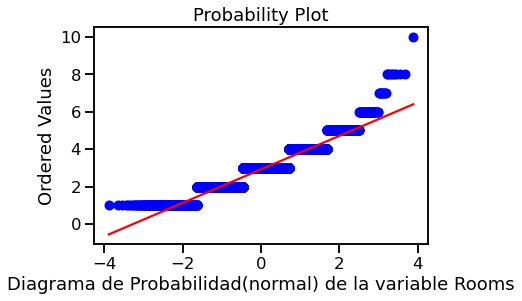

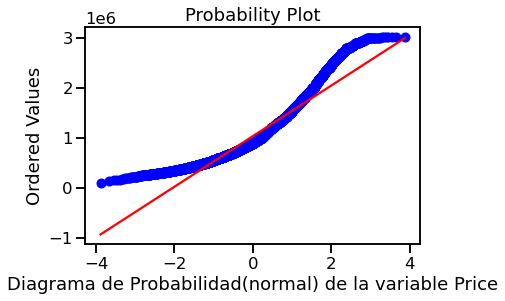

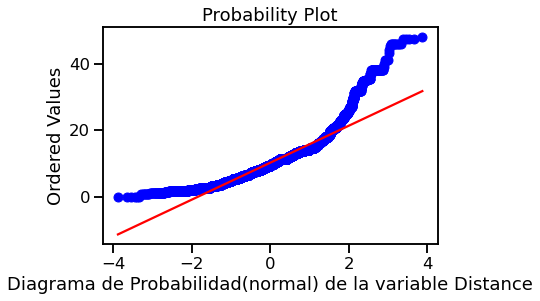

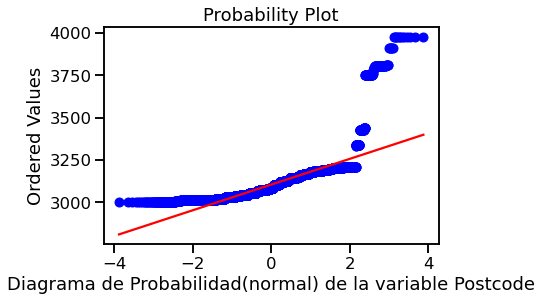

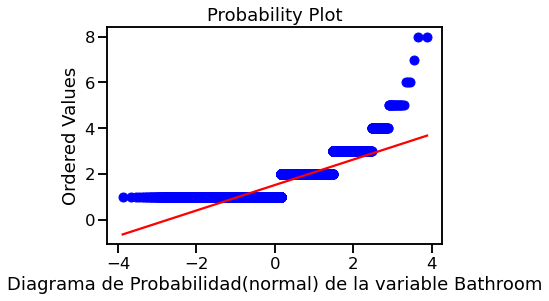

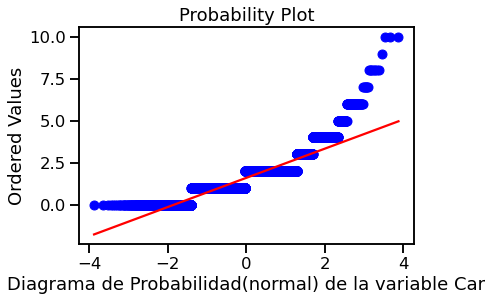

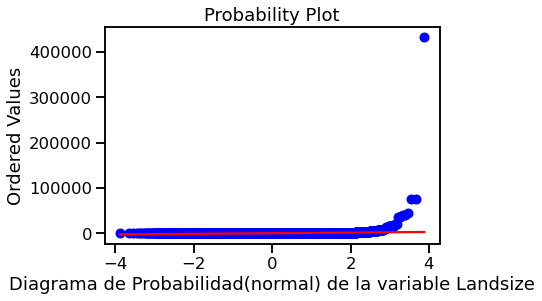

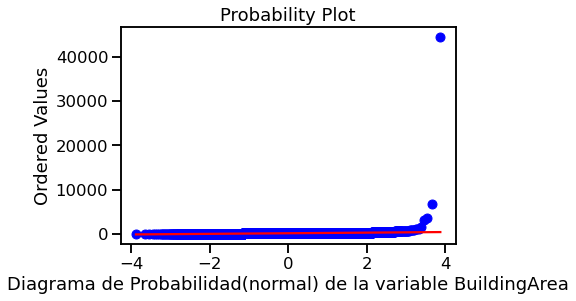

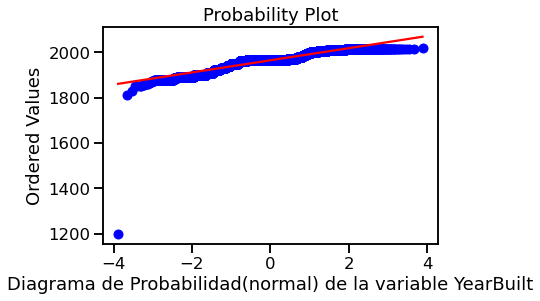

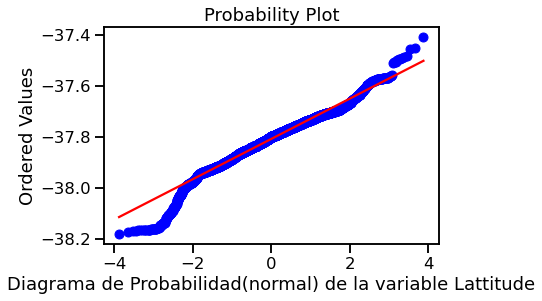

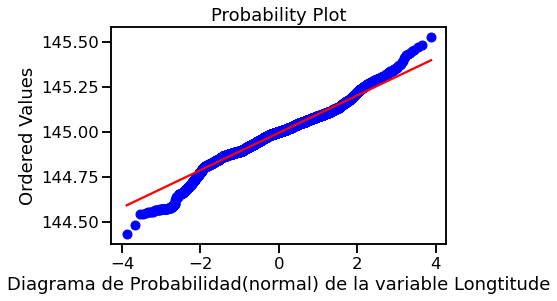

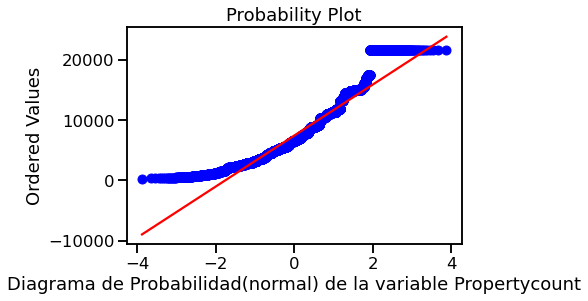

In [21]:
from scipy import stats
def normalidad_variable_numerica(col):
    stats.probplot(df_main_inliers_knn[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()

    
for num_col in columnas_numericas:
    normalidad_variable_numerica(num_col)

### Test de normalidad: 
aceptamos o rechazamos que una variable sigue una distribución normal, para, en el caso de un nivel de confianza de 95%, el pval sea menor o mayor a 0.05.



In [22]:
for num_col in columnas_numericas:
    _, pval = stats.normaltest(df_main_inliers_knn[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))
        

Columna Rooms no sigue una distribución normal
Columna Price no sigue una distribución normal
Columna Distance no sigue una distribución normal
Columna Postcode no sigue una distribución normal
Columna Bathroom no sigue una distribución normal
Columna Car no sigue una distribución normal
Columna Landsize no sigue una distribución normal
Columna BuildingArea no sigue una distribución normal
Columna YearBuilt no sigue una distribución normal
Columna Lattitude no sigue una distribución normal
Columna Longtitude no sigue una distribución normal
Columna Propertycount no sigue una distribución normal


### Histogramas:
Podemos crear un histograma para ver la distribución de una variable.

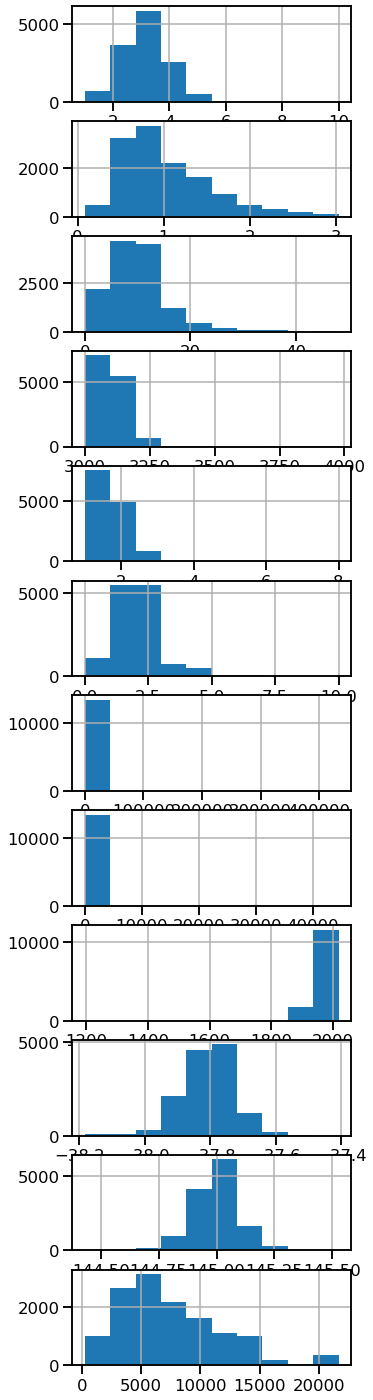

In [23]:
fig, axs = plt.subplots(len(columnas_numericas), figsize=(5, 25))
for n, col in enumerate(columnas_numericas):
    df_main_inliers_knn[col].hist(ax=axs[n])
    

In [24]:
df_main_inliers_knn.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount'],
      dtype='object')

In [25]:
selected_columns = ['Suburb', 'Rooms', 'Type', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt' ]

df_filtered = df_main_inliers_knn[selected_columns]

### Columnas no seleccionadas

- Address, Distance, Method, SeleerG, Date, Distance, CouncilArea, Lattitude, Longitude, Regionname, PropertyCount : se descartan porque considero que no aportan informacion relevante
- Price: es nuestra variable objetico

In [26]:
df_filtered.head()

,Suburb,Rooms,Type,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,Abbotsford,2,h,3067.0,1.0,1.0,202.0,149.469698,1964.997272
1,Abbotsford,2,h,3067.0,1.0,0.0,156.0,79.000000,1900.000000
2,Abbotsford,3,h,3067.0,2.0,0.0,134.0,150.000000,1900.000000
3,Abbotsford,3,h,3067.0,2.0,1.0,94.0,149.469698,1964.997272
4,Abbotsford,4,h,3067.0,1.0,2.0,120.0,142.000000,2014.000000


## 4

Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros


In [27]:
df_filtered['Suburb'].value_counts()[100:]

Glen Waverley    44
Mill Park        43
Aberfeldie       43
Canterbury       43
Fairfield        43
                 ..
Yarra Glen        1
Wallan            1
New Gisborne      1
Kooyong           1
Bullengarook      1
Name: Suburb, Length: 214, dtype: int64

In [28]:
len(df_filtered['Suburb'].value_counts())

314

In [29]:
suburb_replace = df_filtered['Suburb'].value_counts()[100:].index.tolist()

In [30]:
df_filtered['Suburb_2'] = df_filtered['Suburb'].replace(to_replace =suburb_replace, 
                            value ="Others")

df_filtered['Suburb_2'].value_counts()

<ipython-input-30-f33540eb0893>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Suburb_2'] = df_filtered['Suburb'].replace(to_replace =suburb_replace,


Others             2909
Reservoir           359
Richmond            258
Bentleigh East      249
Preston             239
                   ... 
Caulfield South      47
Braybrook            46
Cheltenham           46
Melbourne            46
Ashwood              46
Name: Suburb_2, Length: 101, dtype: int64

In [31]:
df_filtered['Type'].value_counts()

h    9244
u    3016
t    1112
Name: Type, dtype: int64

In [32]:
df_filtered.columns

Index(['Suburb', 'Rooms', 'Type', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'Suburb_2'],
      dtype='object')

## 5

Agregar información adicional respectiva al entorno de una propiedad a partir del conjunto de datos de AirBnB utilizado en el práctico. 

## 6

Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna price, o aplicar múltiples transformaciones como la mediana o el mínimo.

## 7

Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.

In [33]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

Para poder realizar esta combinación de datos, tenemos que encontrar una columna que contenga información en común. Utilizaremos el zipcode.

Sin embargo, este zipcode tiene tipos diferentes, que tendremos que estandarizar antes de continuar con la combinación de los datos.

In [34]:
airbnb_df.zipcode.value_counts()[:5]

3000.0    2491
3000       876
3006.0     860
3182.0     579
3182       556
Name: zipcode, dtype: int64

In [35]:
airbnb_df['zipcode'] = pandas.to_numeric(airbnb_df.zipcode, errors='coerce')

In [36]:
airbnb_df.zipcode.value_counts()

3000.0    3367
3006.0    1268
3182.0    1135
3141.0     881
3004.0     728
          ... 
4068.0       1
3200.0       1
5791.0       1
7266.0       1
2134.0       1
Name: zipcode, Length: 247, dtype: int64

Antes de unir los conjuntos de datos, tenemos que asegurarnos de que tengamos suficientes registros en común como para agregar información relevantes.

In [37]:
intersection = numpy.intersect1d(
    airbnb_df.zipcode.values, df_filtered.Postcode.values, assume_unique=False)
print("Airbnb unique zipcodes", len(airbnb_df.zipcode.unique()))
print("Sales unique zipcodes", len(df_filtered.Postcode.unique()))
print("Common zipcodes", len(intersection))

# interseccion de conjuntos

Airbnb unique zipcodes 248
Sales unique zipcodes 198
Common zipcodes 191


In [38]:
print('Records in Sales df with corresponding zipcode form Sales df',
      df_filtered.Postcode.isin(intersection).sum() / len(df_filtered))
print('Records in Airbnb df with corresponding zipcode form Airbnb df',
      airbnb_df.zipcode.isin(intersection).sum() / len(airbnb_df))

Records in Sales df with corresponding zipcode form Sales df 0.9985043374214777
Records in Airbnb df with corresponding zipcode form Airbnb df 0.9302904564315353


In [42]:
columns_airbnb = ['zipcode', 'price']

airbnb_filtered = airbnb_df[columns_airbnb]

c.head()

,zipcode,price
0,3105.0,60
1,3057.0,35
2,3182.0,159
3,3071.0,50
4,3183.0,69


In [43]:
airbnb_filtered.value_counts()

zipcode  price
3000.0   100      184
         150      158
         109      114
         120      104
3182.0   100       92
                 ... 
3105.0   75         1
         65         1
         47         1
         46         1
30122.0  75         1
Length: 7989, dtype: int64

In [53]:
airbnb_2 = airbnb_filtered.groupby('zipcode').mean().reset_index()[:5]

In [54]:
airbnb_2.value_counts()

zipcode  price     
2010.0   40.000000     1
2134.0   50.000000     1
2582.0   104.000000    1
3000.0   150.504307    1
3001.0   132.500000    1
dtype: int64

In [61]:
# Rename columns
airbnb_2 = airbnb_2.rename(
    columns={'price': 'airbnb_price_mean'})

airbnb_2.head()

,zipcode,airbnb_price_mean
0,2010.0,40.000000
1,2134.0,50.000000
2,2582.0,104.000000
3,3000.0,150.504307
4,3001.0,132.500000


In [62]:
merged_sales_df = df_filtered.merge(
    airbnb_2, how='left',
    left_on='Postcode', right_on='zipcode'
)
merged_sales_df.sample(5)

,Suburb,Rooms,Type,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Suburb_2,zipcode,airbnb_price_mean
4095,Moorabbin,3,h,3189.0,1.0,1.0,653.0,149.469698,1964.997272,Moorabbin,NaN,NaN
5025,Reservoir,3,h,3073.0,2.0,1.0,215.0,149.469698,1964.997272,Reservoir,NaN,NaN
4407,Northcote,3,h,3070.0,1.0,3.0,327.0,165.000000,1900.000000,Northcote,NaN,NaN
11977,South Yarra,2,u,3141.0,1.0,1.0,0.0,64.000000,1965.000000,South Yarra,NaN,NaN
4901,Preston,3,h,3072.0,1.0,1.0,520.0,149.469698,1964.997272,Preston,NaN,NaN


## 8

Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. NO es necesario que realicen la implementación.

## Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.



In [65]:
CouncilArea = df_main_inliers_knn['CouncilArea']

merged_sales_df['CouncilArea'] = CouncilArea

merged_sales_df.head()

,Suburb,Rooms,Type,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Suburb_2,zipcode,airbnb_price_mean,CouncilArea
0,Abbotsford,2,h,3067.0,1.0,1.0,202.0,149.469698,1964.997272,Abbotsford,NaN,NaN,Yarra
1,Abbotsford,2,h,3067.0,1.0,0.0,156.0,79.000000,1900.000000,Abbotsford,NaN,NaN,Yarra
2,Abbotsford,3,h,3067.0,2.0,0.0,134.0,150.000000,1900.000000,Abbotsford,NaN,NaN,Yarra
3,Abbotsford,3,h,3067.0,2.0,1.0,94.0,149.469698,1964.997272,Abbotsford,NaN,NaN,Yarra
4,Abbotsford,4,h,3067.0,1.0,2.0,120.0,142.000000,2014.000000,Abbotsford,NaN,NaN,Yarra


In [70]:
missing_values_count = merged_sales_df['CouncilArea'].isna().sum() 
missing_values_count

1348

In [71]:
missing_values_count = merged_sales_df['Suburb'].isna().sum() 
missing_values_count

0

In [ ]:
merged_sales_df_knn = merged_sales_df.copy(deep=True)

merged_sales_df.fillna({'CouncilArea': }, inplace=True)

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform", missing_values=0)

df_main_inliers_knn[['CouncilArea'] = knn_imputer.fit_transform(merged_sales_df_knn['CouncilArea'])

## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.